## Reffering To

[**YouTube Video**](https://youtu.be/yLz1NELcIM0)

[**DrawData Widget**](https://calmcode.io/labs/drawdata)

In [1]:
import matplotlib.pylab as plt
import numpy as np
import polars as pl
from scipy.optimize import minimize

In [67]:
# Used drawdata. See top cell.
df = pl.read_clipboard(separator=",")
df

x,y,z
f64,f64,str
42.506369,60.76425,"""a"""
-0.084023,126.879736,"""a"""
84.923399,126.772164,"""a"""
102.905868,50.940431,"""a"""
-1.242794,131.689395,"""a"""
…,…,…
130.514443,404.491,"""a"""
107.232467,421.257875,"""a"""
129.231223,385.733671,"""a"""


In [3]:
def calc_all_err(weights):
    pred = weights[0] + weights[1] * df["x"].to_numpy()
    return df["y"].to_numpy() - pred


def calc_err(weights):
    return np.abs(calc_all_err(weights)).sum()

In [4]:
weights = np.array([0, 1])
weights

array([0, 1])

In [6]:
def calc_err(weights, w: int):  # noqa: F811
    errors = calc_all_err(weights)
    weighted_errors = np.where(errors < 0, w * np.abs(errors), (1 - w) * np.abs(errors))
    return weighted_errors.sum()

In [16]:
def plot_pred_quantile(y_pred_top, y_pred_bottom, range):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(df["x"], df["y"], label="original data")
    plt.plot(df["x"], y_pred_top, label="prediction_top", c="orange")
    plt.plot(df["x"], y_pred_bottom, label="prediction_bottom", c="orange")
    plt.legend()

    plt.subplot(1, 2, 2)
    x = np.linspace(-200, 200, 300)

    loss_top = np.where(x < 0, range[0] * np.abs(x), (1 - range[0]) * np.abs(x))
    plt.plot(x, loss_top, label="loss_top")

    loss_bottom = np.where(x < 0, range[1] * np.abs(x), (1 - range[1]) * np.abs(x))
    plt.plot(x, loss_bottom, label="loss_bottom")

    plt.legend()

In [17]:
def predict_top_bottom(df: pl.DataFrame, weights, range):
    opt_weights_top = minimize(calc_err, weights, (range[0],), tol=0.01).x
    y_pred_top = opt_weights_top[0] + opt_weights_top[1] * df["x"].to_numpy()

    opt_weights_bottom = minimize(calc_err, weights, (range[1],), tol=0.01).x
    y_pred_bottom = opt_weights_bottom[0] + opt_weights_bottom[1] * df["x"].to_numpy()

    return y_pred_top, y_pred_bottom

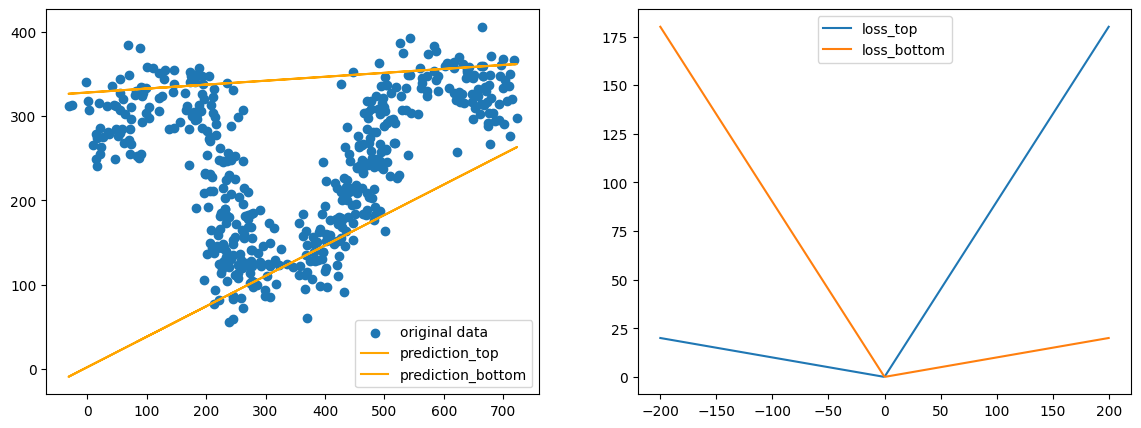

In [18]:
range_ = (0.1, 0.9)
plot_pred_quantile(*predict_top_bottom(df, np.array([0, 1]), range_), range_)

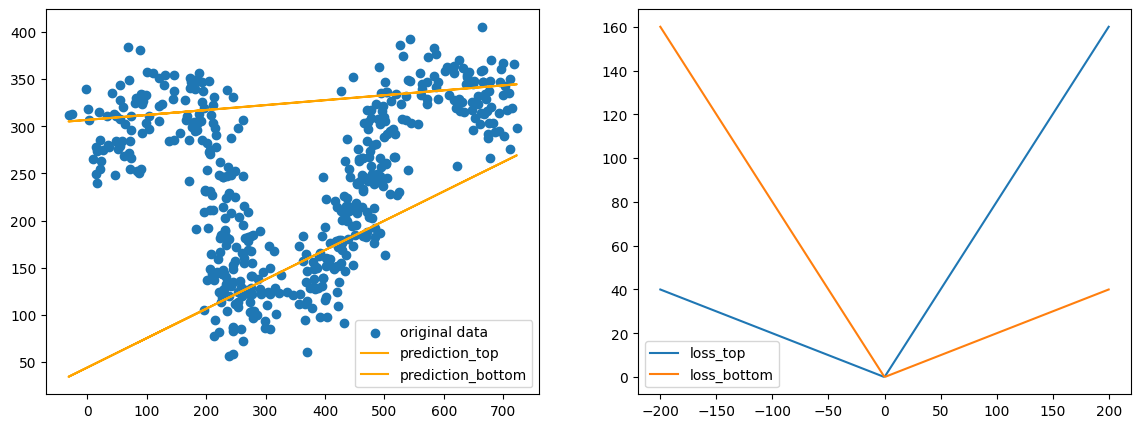

In [19]:
range_ = (0.2, 0.8)
plot_pred_quantile(*predict_top_bottom(df, np.array([0, 1]), range_), range_)

## QuantileRegressor

In [20]:
from sklearn.linear_model import QuantileRegressor

In [59]:
df = df.sort("x")
X = df[["x"]]
y = df["y"]

In [47]:
W = 0.3

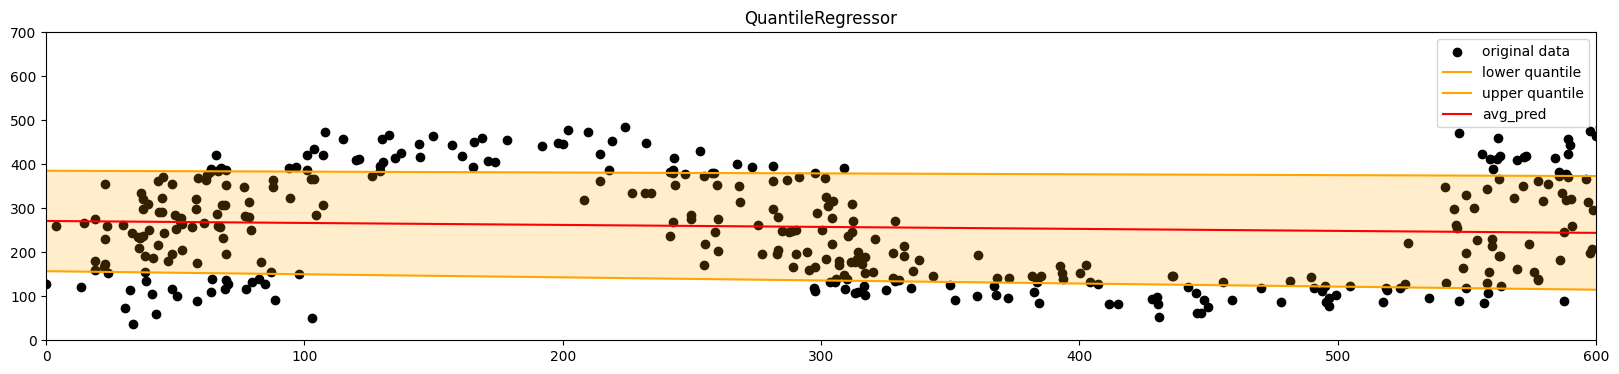

In [60]:
plt.figure(figsize=(20, 4))
m1 = QuantileRegressor(quantile=0.5 - W)
m2 = QuantileRegressor(quantile=0.5 + W)
m1_pred = m1.fit(X, y).predict(X)
m2_pred = m2.fit(X, y).predict(X)
plt.scatter(df["x"], df["y"], label="original data", c="black")
plt.plot(df["x"], m1_pred, label="lower quantile", c="orange")
plt.plot(df["x"], m2_pred, label="upper quantile", c="orange")
plt.plot(df["x"], (m1_pred + m2_pred) / 2, c="red", label="avg_pred")
plt.fill_between(df["x"], m1_pred, m2_pred, color="orange", alpha=0.2)
plt.title("QuantileRegressor")
plt.xlim(0, 600)
plt.ylim(0, 700)
plt.legend()

## HistGradientBoostingRegressor

In [32]:
from sklearn.ensemble import HistGradientBoostingRegressor

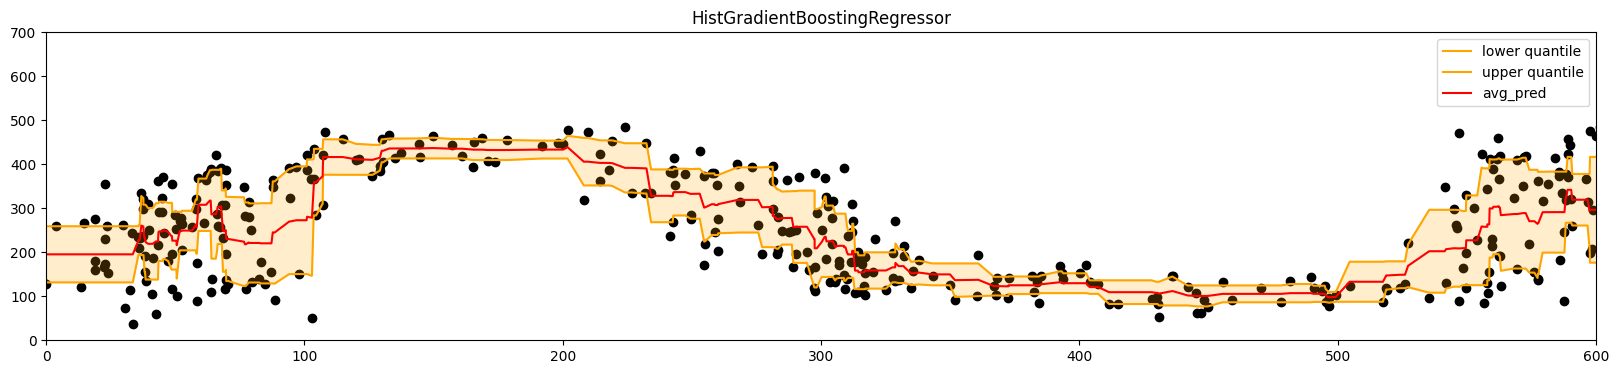

In [65]:
plt.figure(figsize=(20, 4))
m1 = HistGradientBoostingRegressor(
    quantile=0.5 - W,
    loss="quantile",
    l2_regularization=0.2,
)
m2 = HistGradientBoostingRegressor(
    quantile=0.5 + W,
    loss="quantile",
    l2_regularization=0.2,
)
m1_pred = m1.fit(X, y).predict(X)
m2_pred = m2.fit(X, y).predict(X)
plt.scatter(df["x"], df["y"], c="black")
plt.plot(df["x"], m1_pred, label="lower quantile", c="orange")
plt.plot(df["x"], m2_pred, label="upper quantile", c="orange")
plt.plot(df["x"], (m1_pred + m2_pred) / 2, c="red", label="avg_pred")
plt.fill_between(df["x"], m1_pred, m2_pred, color="orange", alpha=0.2)
plt.title("HistGradientBoostingRegressor")
plt.xlim(0, 600)
plt.ylim(0, 700)
plt.legend()

In [66]:
(
    df.with_columns(
        pl.lit(m1_pred).alias("top_pred"),
        pl.lit(m2_pred).alias("bottom_pred"),
    )
    .with_columns(
        pl.col("bottom_pred").sub(pl.col("top_pred")).alias("pred_diff"),
    )
    .drop("z")
)

x,y,top_pred,bottom_pred,pred_diff
f64,f64,f64,f64,f64
-2.705888,145.211681,131.523361,259.172017,127.648656
-1.242794,131.689395,131.523361,259.172017,127.648656
-0.084023,126.879736,131.523361,259.172017,127.648656
3.955123,259.18159,131.523361,259.172017,127.648656
13.688086,120.446534,131.523361,259.172017,127.648656
…,…,…,…,…
625.693264,417.422173,176.40991,416.806991,240.397081
626.649997,180.253108,176.40991,416.806991,240.397081
629.953582,242.874883,176.40991,416.806991,240.397081
